In [1]:
import sys
import os

if not os.path.exists('/data/feilongm/HD163296_radmc3d'):
    os.system('mkdir /data/feilongm/HD163296_radmc3d')

#change to new directory
os.chdir('/data/feilongm/HD163296_radmc3d')

In [2]:
import numpy as np
filename='/data/feilongm/rac-2d/rac-2d-master_2021/storage/HD_163296_COdep_t1e4_3/iter_0001.dat' #change to appropriate path as needed
def load_output(filename):
    output = np.loadtxt(filename, comments='!')
    with open(filename, 'r') as f:
        columnnames = f.readline().split()[1:]
        return dict(zip(np.array(columnnames), output.T))
    
results = load_output(filename)

rac2d_rvals = 0.5*(results['rmin']+results['rmax'])
rac2d_zvals = 0.5*(results['zmin']+results['zmax'])
rac2d_ngas = results['n_gas']
rac2d_temp = results['Tgas']

In [3]:
#combine the arrays we want to output

outputarray = np.stack((rac2d_rvals, rac2d_zvals, rac2d_ngas,rac2d_temp), axis=-1)

#save to file

np.savetxt('HD163296structure.txt',outputarray)

In [4]:
#add radmc3dPy to your Python path
sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy') #edit to match your path

import radmc3dPy
import radmc3dPy.natconst as nc

#these lines set up the model grid (we'll go into that some other time)
rvals = np.logspace(np.log10(0.01), np.log10(800),num=100)
rvalstring='['
for i in rvals:
    rvalstring+=('%0.2e' % i + "*au,")
rvalstring=rvalstring[:-1]+']'

model = radmc3dPy.setup.radmc3dModel(model='ppdisk', 
                                     mstar = [4.e33], #stellar mass in g
                                     gasspec_vturb = 1.e4, #turbulent line broadening parameter (cm/s)
                                     binary=False)

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.
Writing problem_params.inp


In [5]:
#write model grid and store it
model.par.ppar['crd_sys']  = 'sph' #set grid to spherical
model.makeGrid() #initialize grid
model.grid.act_dim = [1,1,0] #2D axisymmetric model
#not to be confused with the Cartesian coordinates x, y, and z
#x corresponds to radius, y corresponds to the polar angle (theta), and z to the azimuthal angle (phi)
model.grid.nxi = 256 #number of cells in first dimension + 1
model.grid.nyi = 65
model.grid.nzi = 2
#setting the walls of the cells
model.grid.xi = np.logspace(np.log10(0.1*nc.au), np.log10(600*nc.au), num=model.grid.nxi) #in cm
model.grid.yi = np.concatenate((np.linspace(0, np.pi/3, num=20)[:-1], np.linspace(np.pi/3., np.pi/2., num=model.grid.nyi+1-20) )) #in radians
model.grid.zi = np.array([0,0]) 

#computing the centers of the cells
model.grid.nx = model.grid.nxi-1 #number of cells along first dimension
model.grid.ny = model.grid.nyi-1
model.grid.nz = model.grid.nzi-1
model.grid.x = (model.grid.xi[1:]+model.grid.xi[:-1])*0.5
model.grid.y = (model.grid.yi[1:]+model.grid.yi[:-1])*0.5
model.grid.z = np.array([0])

model.grid.writeSpatialGrid()
model.grid.writeWavelengthGrid() #just using the default values
model.data = radmc3dPy.analyze.radmc3dData(model.grid)

Writing amr_grid.inp
Writing wavelength_micron.inp


In [6]:
#set up model file description of star
model.makeRadSources(writeToFile=True)

Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------


In [7]:
#write model files for gas velocities (gvel), turbulent velocities (vturb)
#note that gas velocity depends on mstar
model.makeVar(gvel=True, vturb=True, writeToFile=True)

Writing gas_velocity.inp
Writing microturbulence.inp


In [8]:
#checking that the values are set correctly
print(model.par.ppar)

{'incl_cont_stellarsrc': False, 'incl_disc_stellarsrc': True, 'mstar': [4e+33], 'pstar': [0.0, 0.0, 0.0, [0.0, 0.0, 0.0]], 'rstar': [139200000000.0], 'staremis_type': ['blackbody'], 'tstar': [4000.0], 'crd_sys': 'sph', 'grid_style': 0, 'levelMaxLimit': 5, 'nw': [19, 50, 30], 'nx': [30, 50], 'ny': [10, 30, 30, 10], 'nz': [30], 'wbound': [0.1, 7.0, 25.0, 10000.0], 'xbound': [14960000000000.0, 15708000000000.0, 1496000000000000.0], 'xres_nlev': 3, 'xres_nspan': 3, 'xres_nstep': 3, 'ybound': [0.0, 1.0471975511965976, 1.5707963267948966, 2.0943951023931953, 3.141592653589793], 'zbound': [0.0, 6.283185307179586], 'chopforwardt': 0.0, 'dustkappa_ext': ['silicate'], 'errtol': 0.01, 'extrapolate': True, 'gdens': [3.6, 1.8], 'gsdist_powex': -3.5, 'gsmax': 10.0, 'gsmin': 0.1, 'lnk_fname': ['/disk2/juhasz/Data/JPDOC/astrosil/astrosil_WD2001_new.lnk'], 'logawidth': 0, 'mixabun': [0.75, 0.25], 'na': 20, 'ngs': 1, 'nscatang': 180, 'verbose': False, 'wfact': 3.0, 'gasspec_colpart_abun': [1.0], 'gasspe

In [9]:
from scipy.interpolate import LinearNDInterpolator


# write temperature structure

def writeGasTemp(radmc3dpy_model, structurefile):
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_temp = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au #convert from au to cm
    rac2d_z = HD163296structure[:,1]*nc.au #convert from au to cm
    rac2d_temp =  HD163296structure[:,3] #K
    
    #mirror the model for the lower half of the disk so interpolation at the midplane is reasonable
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_temp =  np.concatenate((rac2d_temp, rac2d_temp))

    
    temp_interp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), rac2d_temp, fill_value=3.)
    
    #here, x, y, and z do NOT refer to Cartesian coordinates, but in this case correspond to the three spherical coordinates
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                #convert from spherical to cylindrical coordinates
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                tempval = temp_interp(r_cyl,z)
                if tempval>1.e5:
                    radmc3d_temp[i,j,k] = 99999.
                else:
                    radmc3d_temp[i,j,k] = temp_interp(r_cyl,z)
                
    radmc3dpy_model.data.gastemp = radmc3d_temp
    radmc3dpy_model.data.writeGasTemp(binary=False)
                
def writeCONumDens(radmc3dpy_model, structurefile, upperheight=0.35, lowerheight = 0.25 ):
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_CONumDens = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au #convert from au to cm
    rac2d_z = HD163296structure[:,1]*nc.au #convert from au to cm
    rac2d_ngas = HD163296structure[:,2] #in cm^-3
    
    #mirror the model for the lower half of the disk so interpolation at the midplane is reasonable
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_ngas =  np.concatenate((rac2d_ngas, rac2d_ngas))
    
    logngasinterp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), np.log10(rac2d_ngas),fill_value=1.e-20)
    
    #here, x, y, and z do NOT refer to Cartesian coordinates, but in this case correspond to the three spherical coordinates
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                #convert from spherical to cylindrical coordinates
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                ngas = 10**logngasinterp(r_cyl,z)
                if lowerheight< z/r_cyl < upperheight:
                    radmc3d_CONumDens[i,j,k] = 1.e-5*ngas
                else:
                    radmc3d_CONumDens[i,j,k] = 1.e-20
    radmc3dpy_model.data.ndens_mol = radmc3d_CONumDens
    radmc3dpy_model.data.writeGasDens(ispec='co',binary=False)
                    
    
HD163296file = '/data/feilongm/HD163296_radmc3d/HD163296structure.txt' #change to appropriate path as needed
    
writeGasTemp(model, HD163296file)
writeCONumDens(model, HD163296file,upperheight = 0.35, lowerheight=0.25)

Writing gas_temperature.inp
Writing numberdens_co.inp


Text(0, 0.5, 'z (au)')

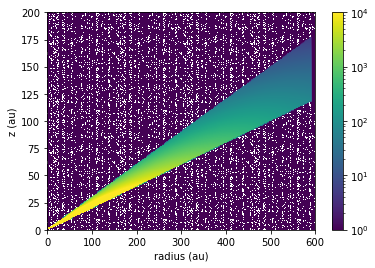

In [10]:
#instead of using the CO distribution from RAC2D, for now we're just using a simplified distribution so that you can test how changing the distribution affects the simulated molecular emission
#Here is a plot of the simplified CO distribution as a function of r and z
import matplotlib.pyplot as plt
import matplotlib.colors as col

logngasinterp = LinearNDInterpolator(list(zip(rac2d_rvals, rac2d_zvals)), np.log10(rac2d_ngas),fill_value=1.e-20)
rgrid, zgrid = np.mgrid[0:600:300j, 0:200:200j] #specify a regular grid going from r=0 to 600 spaced evenly by 300 gridpoints and z=0 to 200 spaced evenly by 200 gridpoints
simpleCOdistribution = np.zeros_like(rgrid)
for i in range(300):
    for j in range (200):
        if rgrid[i,j]>0 and 0.2< zgrid[i,j]/rgrid[i,j]<0.3:
            simpleCOdistribution[i,j] = 10**logngasinterp(rgrid[i,j], zgrid[i,j])*1.e-4
        else:
            simpleCOdistribution[i,j] = 1.e-20
            
plt.imshow(simpleCOdistribution.T, origin='lower', aspect='auto', norm=col.LogNorm(vmin=1., vmax = 1.e4),
               extent = [np.min(rgrid),np.max(rgrid), np.min(zgrid), np.max(zgrid)])
plt.colorbar()
plt.xlabel('radius (au)')
plt.ylabel('z (au)')

In [11]:
#copy over CO line data

os.system('cp -v /shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy/python_examples/datafiles/molecule_co.inp .') # change to correct path
model.writeLinesInp()

Writing lines.inp


In [12]:
# Write the radmc3d.inp file (but you don't have to understand what it means yet)
model.par.ppar['lines_mode']=1
model.par.ppar['tgas_eq_tdust']=0
model.writeRadmc3dInp()

Writing radmc3d.inp


In [13]:
# now simulate an image cube (this will take a few minutes to run). 

radmc3dPy.image.makeImage(npix=512., #number of pixels
                          incl=40., #disk inclination angle
                          phi=0., #position angle
                          sizeau=1200.,
                          widthkms=5, #calculate spectrum between +5 and -5 km/s
                          linenlam=15, #number of wavelengths at which to calculate the spectrum
                          iline=2) #molecular transition to simulate

Executing RADMC-3D Command:
radmc3d image npix 512 incl 40.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2


0

In [14]:
im = radmc3dPy.image.readImage(fname='image.out')

Reading image.out


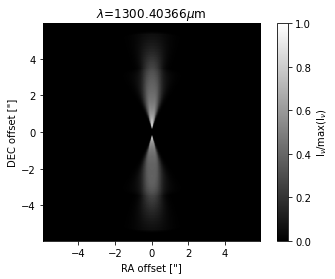

{'implot': <matplotlib.image.AxesImage at 0x7fe27f66ae50>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fe28749d9d0>}

In [15]:
#plot a few different channels of the resulting image cube
radmc3dPy.image.plotImage(im, arcsec=True, dpc=101., ifreq=7)

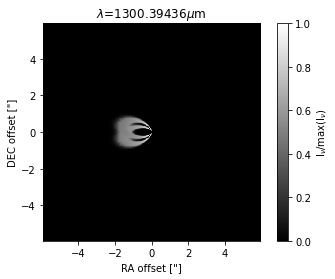

{'implot': <matplotlib.image.AxesImage at 0x7fe2874f7f40>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fe27f653970>}

In [16]:
radmc3dPy.image.plotImage(im,arcsec=True, dpc=101., ifreq=4)

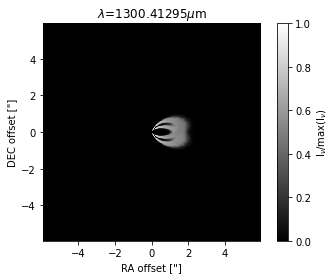

{'implot': <matplotlib.image.AxesImage at 0x7fe27f5fdeb0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fe27f5b77c0>}

In [17]:
radmc3dPy.image.plotImage(im,arcsec=True, dpc=101., ifreq=10)

In [18]:
##################################################################################

In [19]:
##################################################################################

In [20]:
##################################################################################

In [21]:
import sys
import os
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib.colors as col

#add parameters

def setDirectories():
    if not os.path.exists('/data/feilongm/HD163296_radmc3d'):
        os.system('mkdir /data/feilongm/HD163296_radmc3d')
    os.chdir('/data/feilongm/HD163296_radmc3d')

def load_output():
    filename='/data/feilongm/rac-2d/rac-2d-master_2021/storage/HD_163296_COdep_t1e4_3/iter_0001.dat'
    output = np.loadtxt(filename, comments='!')
    with open(filename, 'r') as f:
        columnnames = f.readline().split()[1:]
        return dict(zip(np.array(columnnames), output.T))

#results = load_output(filename)

def saveFile(results):
    import radmc3dPy
    import radmc3dPy.natconst as nc
    rac2d_rvals = 0.5*(results['rmin']+results['rmax'])
    rac2d_zvals = 0.5*(results['zmin']+results['zmax'])
    rac2d_ngas = results['n_gas']
    rac2d_temp = results['Tgas']
    outputarray = np.stack((rac2d_rvals, rac2d_zvals, rac2d_ngas,rac2d_temp), axis=-1)
    np.savetxt('HD163296structure.txt',outputarray)
    sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy')

def setModelGrid(mstar_in, gasspec_vturb_in):
    rvals = np.logspace(np.log10(0.01), np.log10(800),num=100)
    rvalstring='['
    for i in rvals:
        rvalstring+=('%0.2e' % i + "*au,")
    rvalstring=rvalstring[:-1]+']'
    model = radmc3dPy.setup.radmc3dModel(model='ppdisk', 
                                         mstar = [mstar_in], #custom mstar
                                         gasspec_vturb = gasspec_vturb_in, #custom gasspec_vturb
                                         binary=False)
    model.par.ppar['crd_sys']  = 'sph'
    model.makeGrid()
    model.grid.act_dim = [1,1,0]
    model.grid.nxi = 256
    model.grid.nyi = 65
    model.grid.nzi = 2
    model.grid.xi = np.logspace(np.log10(0.1*nc.au), np.log10(600*nc.au), num=model.grid.nxi)
    model.grid.yi = np.concatenate((np.linspace(0, np.pi/3, num=20)[:-1], np.linspace(np.pi/3., np.pi/2., num=model.grid.nyi+1-20) )) #in radians
    model.grid.zi = np.array([0,0]) 
    model.grid.nx = model.grid.nxi-1
    model.grid.ny = model.grid.nyi-1
    model.grid.nz = model.grid.nzi-1
    model.grid.x = (model.grid.xi[1:]+model.grid.xi[:-1])*0.5
    model.grid.y = (model.grid.yi[1:]+model.grid.yi[:-1])*0.5
    model.grid.z = np.array([0])
    model.grid.writeSpatialGrid()
    model.grid.writeWavelengthGrid()
    model.data = radmc3dPy.analyze.radmc3dData(model.grid)
    model.makeRadSources(writeToFile=True)
    model.makeVar(gvel=True, vturb=True, writeToFile=True)

def writeGasTemp(radmc3dpy_model, structurefile):
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_temp = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au 
    rac2d_z = HD163296structure[:,1]*nc.au 
    rac2d_temp =  HD163296structure[:,3] 
    
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_temp =  np.concatenate((rac2d_temp, rac2d_temp))

    
    temp_interp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), rac2d_temp, fill_value=3.)
    
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                tempval = temp_interp(r_cyl,z)
                if tempval>1.e5:
                    radmc3d_temp[i,j,k] = 99999.
                else:
                    radmc3d_temp[i,j,k] = temp_interp(r_cyl,z)
                
    radmc3dpy_model.data.gastemp = radmc3d_temp
    radmc3dpy_model.data.writeGasTemp(binary=False)

def writeCONumDens(radmc3dpy_model, structurefile, upperheight_in, lowerheight_in):
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_CONumDens = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au 
    rac2d_z = HD163296structure[:,1]*nc.au 
    rac2d_ngas = HD163296structure[:,2] 
    
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_ngas =  np.concatenate((rac2d_ngas, rac2d_ngas))
    
    logngasinterp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), np.log10(rac2d_ngas),fill_value=1.e-20)
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                ngas = 10**logngasinterp(r_cyl,z)
                if lowerheight_in< z/r_cyl < upperheight_in:
                    radmc3d_CONumDens[i,j,k] = 1.e-5*ngas
                else:
                    radmc3d_CONumDens[i,j,k] = 1.e-20
    radmc3dpy_model.data.ndens_mol = radmc3d_CONumDens
    radmc3dpy_model.data.writeGasDens(ispec='co',binary=False)

def writeIn(upperheight_in, lowerheight_in):
    HD163296file = '/data/feilongm/HD163296_radmc3d/HD163296structure.txt' #change to appropriate path as needed
    writeGasTemp(model, HD163296file)
    writeCONumDens(model, HD163296file, upperheight_in, lowerheight_in)

def getPlot():
    logngasinterp = LinearNDInterpolator(list(zip(rac2d_rvals, rac2d_zvals)), np.log10(rac2d_ngas),fill_value=1.e-20)
    rgrid, zgrid = np.mgrid[0:600:300j, 0:200:200j] #specify a regular grid going from r=0 to 600 spaced evenly by 300 gridpoints and z=0 to 200 spaced evenly by 200 gridpoints
    simpleCOdistribution = np.zeros_like(rgrid)
    for i in range(300):
        for j in range (200):
            if rgrid[i,j]>0 and 0.2< zgrid[i,j]/rgrid[i,j]<0.3:
                simpleCOdistribution[i,j] = 10**logngasinterp(rgrid[i,j], zgrid[i,j])*1.e-4
            else:
                simpleCOdistribution[i,j] = 1.e-20        
    plt.imshow(simpleCOdistribution.T, origin='lower', aspect='auto', norm=col.LogNorm(vmin=1., vmax = 1.e4),
               extent = [np.min(rgrid),np.max(rgrid), np.min(zgrid), np.max(zgrid)])
    plt.colorbar()
    plt.xlabel('radius (au)')
    plt.ylabel('z (au)')

def copyDataAndWriteFile():
    os.system('cp -v /shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy/python_examples/datafiles/molecule_co.inp .') # change to correct path
    model.writeLinesInp()
    model.par.ppar['lines_mode']=1
    model.par.ppar['tgas_eq_tdust']=0
    model.writeRadmc3dInp()

def simulateImageCube(incl_in):
    radmc3dPy.image.makeImage(npix=512.,
                          incl=incl_in,
                          phi=0.,
                          sizeau=1200.,
                          widthkms=5,
                          linenlam=15,
                          iline=2) 
def plotImage():
    im = radmc3dPy.image.readImage(fname='image.out')
    radmc3dPy.image.plotImage(im, arcsec=True, dpc=101., ifreq=7)
    radmc3dPy.image.plotImage(im,arcsec=True, dpc=101., ifreq=4)
    radmc3dPy.image.plotImage(im,arcsec=True, dpc=101., ifreq=10)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 24.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


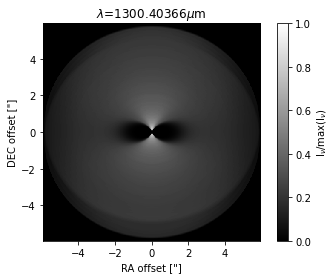

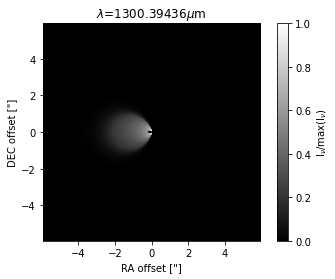

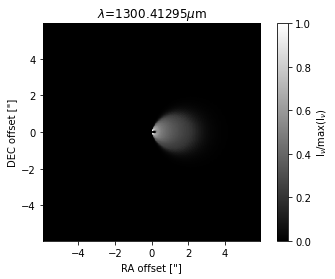

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 30.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


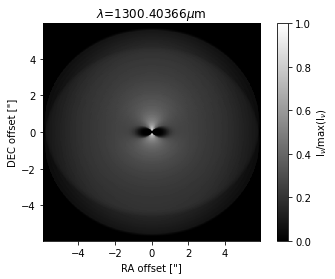

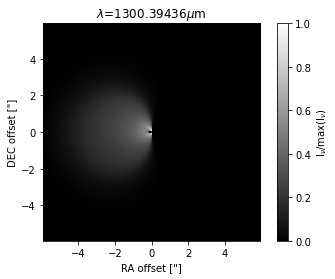

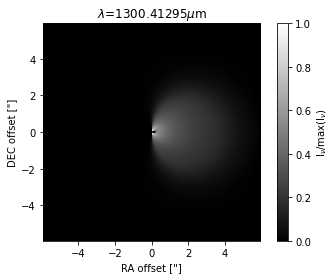

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 36.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


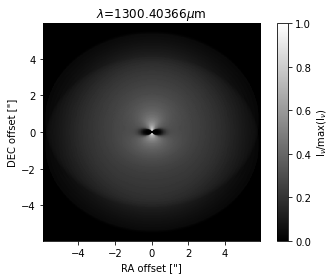

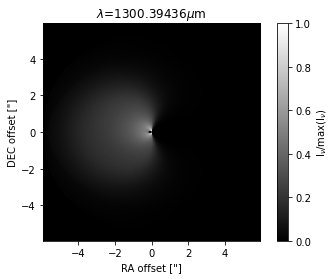

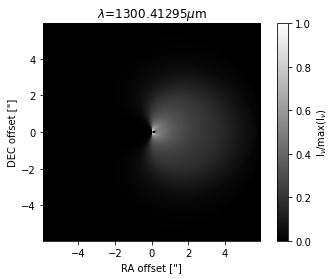

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 42.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


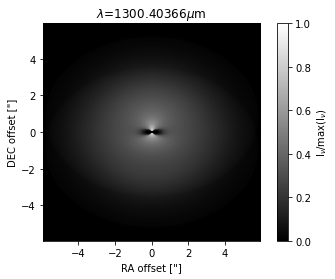

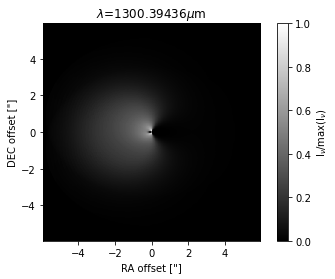

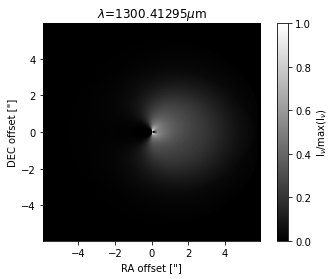

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 48.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


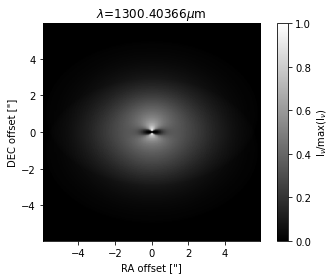

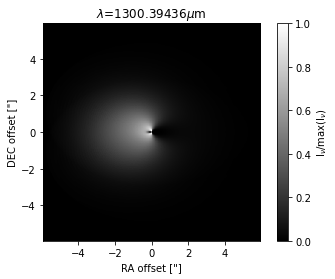

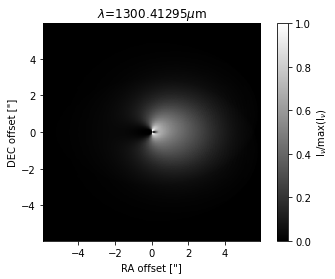

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 54.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


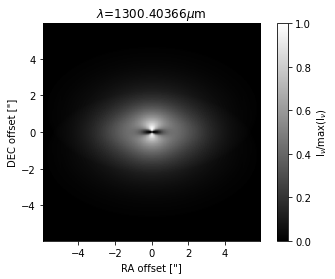

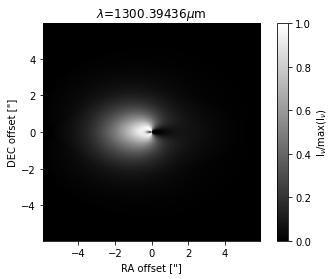

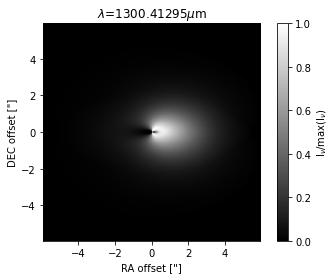

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 60.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


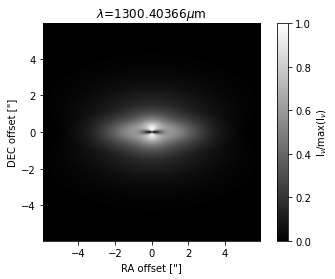

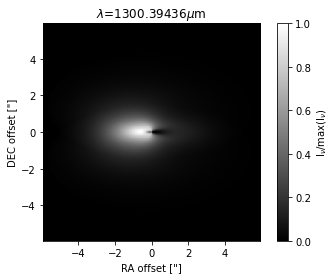

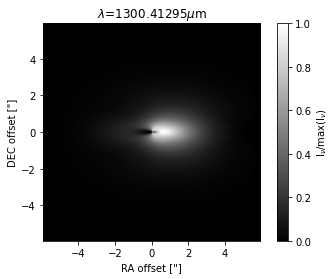

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 66.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


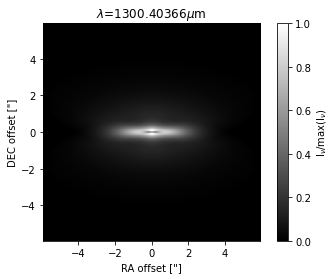

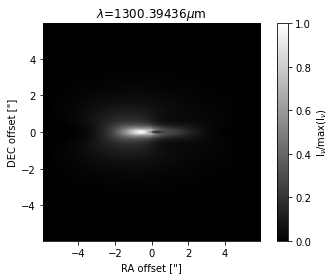

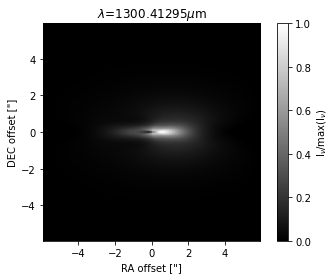

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 72.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


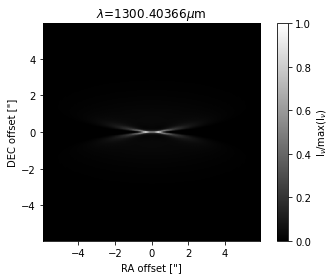

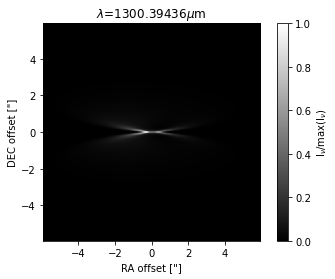

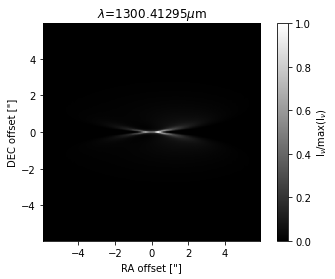

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 78.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


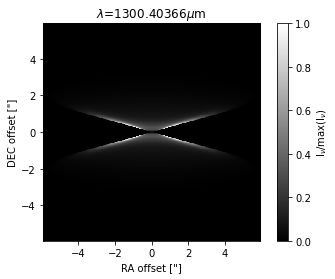

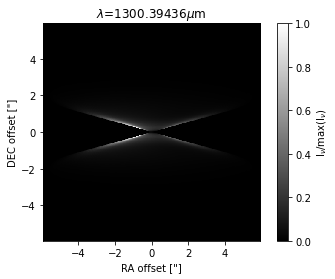

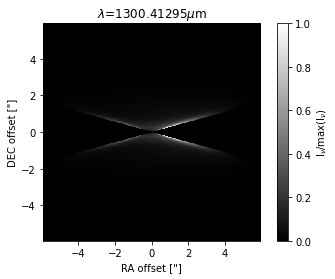

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 84.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


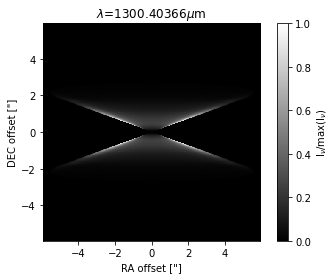

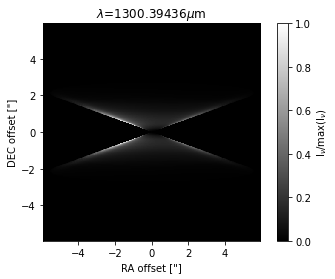

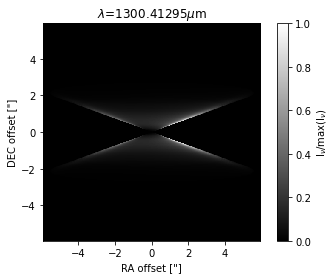

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 512 incl 90.0 sizeau 1200.0 widthkms 5 linenlam 15 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading image.out


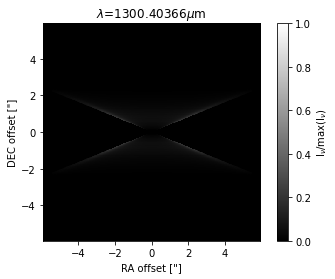

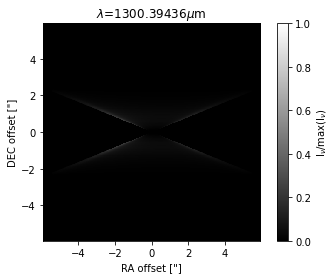

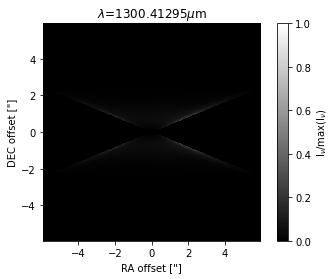

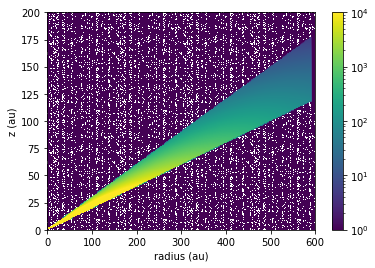

In [22]:
def RADMC3D(mstar_in, gasspec_vturb_in, upperheight_in, lowerheight_in, incl_in):
    setDirectories()
    results = load_output()
    saveFile(results)
    setModelGrid(mstar_in, gasspec_vturb_in)
    writeIn(upperheight_in, lowerheight_in)
    copyDataAndWriteFile()
    simulateImageCube(incl_in)
    plotImage()
    getPlot()

mstar_in = 4.e33
gasspec_vturb_in = 1.e4
upperheight_in = 0.2
lowerheight_in = 0.1
incl_in = 18.

for i in range(0, 12):
    mstar_in -= 25.e31
    gasspec_vturb_in += 4.e4
    upperheight_in += 0.025
    lowerheight_in += 0.025
    incl_in += 6.
    RADMC3D(mstar_in, gasspec_vturb_in, upperheight_in, lowerheight_in, incl_in)